# Capstone Project: Sentiment T Stocks in the WallStreetBets subreddit

# Stage 1: Getting the Data

## Key Modules

In [299]:
import praw                        # Python Reddit API Wrapper, some useful classes and methods for ease of access
import datetime                    # Used to gather unix timestamps for posts and convert them into a useful format
# from bs4 import BeautifulSoup
import pandas as pd                # Used to handle data and generate and save csv file of gathered data to avoid
                                    ## data loss

## Setting up the API Wrapper

In [ ]:
# Authentication variables go here :)
client_id = "" #API token, generated by the RedditAPI
client_secret = "" #API token, generated by the RedditAPI
user_agent = "" #app name, specified when initialising RedditAPI
username = "" #Reddit profile username
password = "" #Reddit profile password

## Key Functions

In [303]:
def connect_to(subreddit_name):
    '''
    Requires 1 passed argument: The name of the subreddit you wish to connect to as a string.
    Functionality: 
        1. Creates a reddit object using the PRAW module and pre-defined user credentials,
        2. Verifies authentication of the pre-defined user credentials, and therefore, connection to the API
            by printing username,
        3. Connects to the subreddit specified by the passed argument "subreddit_name" and returns 
            a PRAW subred object.
    '''
    # Create an instance of the API wrapper using the authentication credentials defined above
    reddit = praw.Reddit(client_id = client_id,
                        client_secret = client_secret,
                        user_agent = user_agent,
                        username = username,
                        password = password)
    # Verify authenticatio 
    print(reddit.user.me())                                  # Verify the authentication worked - this will print your username if so...
   
    # Connect to the subreddit, generating a subred object
    subred = reddit.subreddit("wallstreetbets")              # Create a subreddit object for the WallStreetBets subreddit
    return subred

In [305]:
def get_date(submission):
    '''
    Requires 1 passed argument: A submission object, a.k.a. a post represented by the "submission" object by the PRAW module.
    Functionality: Takes the creation timestamp (unix) from the praw API and converts it to a timestamp for use in Python,
    returning the converted datetime value.
    Sourced from: https://www.reddit.com/r/learnprogramming/comments/37kr5n/praw_is_it_possible_to_get_post_time_and_date/
    '''
    time = submission.created
    return datetime.datetime.fromtimestamp(time)

In [307]:
def subreddit_post_scraper(subred, lmt=None):
    '''
    Requires 1 passed argument: subred, a subred object created using the 'connect_to()' function,
    An optional passed argument: lmt, represents the total number of posts desired. 
        The redditAPI limits requests to 1000 posts and this is the default limit of this function.
    Functionality:
        1. Iterates through each submission/post in a subreddit from newest to oldest,
        2. Creates a dictionary of key metadata for a given post,
        3. Appends this dictionary to a list of posts named 'posts',
        4. Returns the finalised list containing all of the retrieved posts.
    Understanding the metadata: Metadata objects gathered by the dictionary definition can
        be further understood by reading the PRAW documentation (here): 
            https://praw.readthedocs.io/en/stable/code_overview/models/submission.html#praw.models.Submission
    '''
    posts = [] #array for holding reddit posts
    comment_forests = {} #dictionary for holding comment thread with associated post: by post ID

    #GRAB POSTS TO THE WSB SUBREDDIT
    for submission in subred.new(limit=lmt):            #grabs the specified # of posts as possible in chronological order
        posts.append({'id':submission.id,               #appends a dictionary with key post info to the posts array
                      'upvotes':submission.score,
                      'liketodislike_ratio':submission.upvote_ratio,
                      'num_comments':submission.num_comments,
                      'title':submission.title,
                      'body':submission.selftext,
                      'timestamp':get_date(submission) #uses the get_date function to convert utc time to python timestamp
                       })
    return posts #output the text data and metadata for the posts list 

## Scraping the Subreddit

In [309]:
# Running the web-scraping code
subred = connect_to("wallstreetbets")                  # connect to the subreddit
posts = subreddit_post_scraper(subred)                 # grab the latest 1000 posts
data = pd.DataFrame.from_dict(posts)                   # convert the list of dictionaries representing posts to a dataframe
data.to_csv('data_for_analysis_WSB.csv',index=False)   # save the collected data as a csv file

Imaginary-Ad-3027


# Stage 2: Running the Model

## Key Modules

In [312]:
#pandas for manipulating dataframes, importing tabular format data, and saving data as csv files.
import pandas as pd
# regular expressions for identifying stock market tickers in text.
import re                                                       
# VADER to be used as the main tool for analysing text based sentiment.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Main Functions

In [314]:
def customize_vader_analyzer(custom_lexicon_path):
    '''
    Requires 1 passed argument: a file path as a string for a text file containing terms and 
    corresponding VADER sentiment scores.
    Functionality: Creates a customised sentiment analysis model using VADER and a locally saved text file acting as an update
    to the model's lexicon of words and their sentiment scores.
    1. Opens a specified file from the file path passed to the function.
       - Scans each line in the file expecting a format of: "{word/phrase} {VADER sentiment score}".
       - Saves words and their sentiment score to a dictionary as a key-value pair.
    2. Generates a pre-trained sentiment analysis model using the VADER library.
       - Updates the lexicon of the model to include novel/bespoke words and phrases specified in the dictionary.
       - returns the updated model
    '''
    # 0. DEFINING VARIABLES
    custom_lexicon = {}
    
    # 1. CONVERTING THE CUSTOM LEXICON TEXT FILE INTO A DICTIONARY COMPATIBLE WITH VADER
    with open(custom_lexicon_path, encoding="utf8") as txt_file:     #open custom lexicon text file
        for line in txt_file:                       #iterate through each line in the file
            term,score = line.split()               #unpack the slang or word and corresponding VADER sentiment score
            custom_lexicon[term] = float(score)     #append the term and it's score to the dictionary as a key/val pair

    # 2. GENERATING A VADER ANALYSIS MODEL AND UPDATING IT WITH THE CUSTOM LEXICON
    analyzer = SentimentIntensityAnalyzer()         #instantiate a VADER analyzer object for the model
    analyzer.lexicon.update(custom_lexicon)         #update the analyzer with the custom_lexicon dictionary
    return analyzer                                 #return the updated model

In [316]:
def extract_tickers(text):
    '''
    Requires 1 passed argument: a body of text as a string.
    Functionality: Uses regular expressions to identify and return any stock market 'tickers' or 
    WallStreetBets 'cashtags' in a body of text passed to the function.
       - A cashtag is a stock market ticker preceeded by the $ sign (e.g. $NVDA,cashtag = NVDA,ticker).
       - Tickers are returned as a list on unique tickers/cashtags found within the text.
       - Tickers and their equivalent cashtags are compared and duplicates are removed.
    '''
    cashtags = re.findall(r'\$[A-Za-z]+', text)   # Extract cashtags using regex
    tickers = re.findall(r'\b[A-Z]{1,5}\b', text) # Extract standalone tickers (assuming tickers are uppercase and 1-5 letters long)
    cashtags = [tag[1:] for tag in cashtags]      # Remove dollar signs from cashtags for comparison with market tickers
    all_tickers = list(set(cashtags + tickers))   # Combine, deduplicate, and sort
    
    # cross-reference tickers with yfinance to remove non-tickers caught by the regex
    verified_tickers = []
    for ticker in all_tickers:
        try:
            stock = yf.Ticker(ticker)
            if stock.info['regularMarketPrice'] is not None:
                verified_tickers.append(ticker)
        except Exception:
            pass


    
    return all_tickers                            # Return the tickers as a list of strings, each string represented a stock

In [318]:
def extract_tickers(text,list_of_tickers_path):
    '''
    Requires 2 passed argument: 
        1. a body of text as a string to be analysed,
        2. a csv file containing a column of valid market tickers to verify patterns caught by the regex.
    Functionality: Uses regular expressions to identify and return any stock market 'tickers' or 
    WallStreetBets 'cashtags' in a body of text passed to the function.
       - A cashtag is a stock market ticker preceeded by the $ sign (e.g. $NVDA,cashtag = NVDA,ticker).
       - Tickers are returned as a list on unique tickers/cashtags found within the text.
       - Tickers and their equivalent cashtags are compared and duplicates are removed.
    '''
    # 1. EXTRACTING CASHTAGS / STOCK MARKET TICKERS FROM TEXT
    cashtags = re.findall(r'\$[A-Za-z]+', text)   # Extract cashtags using regex
    tickers = re.findall(r'\b[A-Z]{1,5}\b', text) # Extract standalone tickers (assuming tickers are uppercase and 1-5 letters long)
    cashtags = [tag[1:] for tag in cashtags]      # Remove dollar signs from cashtags for comparison with market tickers
    all_tickers = list(set(cashtags + tickers))   # Combine, deduplicate, and sort

    # 2. GENERATING A LIST FROM CSV FILE OF VALID PUBLICLY TRADED STOCK TICKERS
    list_of_tickers = pd.read_csv(list_of_tickers_path)
    valid_tickers = list(list_of_tickers['Ticker'])   # Assumes the column is titled "Ticker"
    
    # Verify tickers using Yahoo Finance endpoint
    verified_tickers = []
    for ticker in all_tickers:
        if ticker in valid_tickers:
            verified_tickers.append(ticker)

    return verified_tickers  # Return the tickers as a list of strings, each string representing a stock

In [320]:
def determine_stock_sentiment(text, analyzer):
    '''
    Requires 2 passed arguments: 
        1. text = a body of text as a string (i.e. the text from a reddit post), 
        2. analyzer = an instantiated VADER sentiment analysis model, updated using a custom lexicon to
            interpret slang terminology of the WallStreetBets subreddit (created by the customize_vader_analyzer function).
    Functionality: Returns the sentiment score for the passed post. Checks the text of a passed post to identify key slang terminology relating to stock performance.
        - Posts containing slang terms to do with positive stock performance are awarded a positive sentiment (e.g. 1).
        - Posts containing slang terms to do with negative stock performance are awarded a negative sentiment (e.g. -1).
    If there are no slang terms present in the post sentiment score is based on the compound VADER sentiment score
        generated by the customised VADER model.
    '''
    sentiment_score = analyzer.polarity_scores(text)['compound']      # Generate a sentiment score for the passed text
    post_sentiment = 0                                                # initialise a variable to hold post sentiment
    
    # if any of the slang for positive stock performance is present in the text...
    if any(term in text for term in ['bullish', '🚀', '📈', 'calls', 'long', 'buy', 'pump', 'uptrend', 'bull', 'short squeeze']):
        post_sentiment = 1                                            # post_sentiment = positive

    # else, if any of the slang for negative stock performance is present...
    elif any(term in text for term in ['bearish', '📉', 'puts', 'short', 'sell', 'dump', 'downtrend', 'bear']):
        post_sentiment = -1                                           # post sentiment = negative
    
    # else if VADER compound score is above the positive threshold...
    elif sentiment_score > 0.05:  
        post_sentiment = 1                                            # post sentiment = positive

    # else if VADER compound score is below the negative threshold...
    elif sentiment_score < -0.05:                                     
        post_sentiment = -1                                           # post sentiment = negative

    # if the VADER compound score is in the neutral range,
    ## and no key terms where identified in the text related to stock performance...
    else:
        post_sentiment  = 0                                           # post sentiment = neutral

    return post_sentiment                                          # return the dictionary to be added as a column of a dataframe

In [322]:
def fetch_and_clean_data(path_to_data):
    '''
    Requires 1 passed argument: The file path to the csv file of subreddit data.
    Functionality: Takes a csv file of data gathered from the WallStreetBets subreddit
    and returns an engineered pandas dataframe for use in a sentiment analysis of the posts.
    '''
    df = pd.read_csv(path_to_data)                    # Load CSV file data
    df['title'].fillna(" ",inplace=True)               # remove non-string values from the title column
    df['body'].fillna(" ",inplace=True)                # remove non-string values from the body column
    df['text'] = df['title'] + " " + df['body']       # combine title and body text in a new column to analyse together
    return df                                         # return the a dataframe of the engineered data, ready for analysis

## Running the Analysis

In [324]:
#fetch the data using a function
df = fetch_and_clean_data("data_for_analysis_WSB.csv")            # pass the path to the csv file containing the reddit data

# Initialize custom VADER analyzer
analyzer = customize_vader_analyzer("custom_vader_lexicon_2.txt") # pass the custom lexicon text file

# Lists to store data for making new columns in the dataframe
stock_sentiments = []
stock_mentions = []

# Iterate through the dataframe's posts
for index, row in df.iterrows():
    text = row['text']                                            # grab the text (from the text column) for a given row
    cashtags = extract_tickers(text,"stock_market_tickers.csv")   # extract cashtags/tickers using pre-made function
    stock_mentions.append(cashtags)                               # append cashtags to stock mentioned list for new df column

    # Determine stock sentiment if any cashtags are mentioned
    if cashtags:
        stock_sentiment = determine_stock_sentiment(text, analyzer)
    # Otherwise, do not measure post sentiment
    else:
        stock_sentiment = None
        
    # Append the sentiment for each post to a list
    stock_sentiments.append(stock_sentiment)

# Add new columns to the DataFrame
df['stock_sentiment'] = stock_sentiments       # add the calculated sentiment for each post as a column
df['stock_mentions'] = stock_mentions          # add the list of stock tickers found per each post as a column

# Remove observations that do not reference any stocks.
df.dropna(inplace=True)

# Save the updated DataFrame to a new CSV file
df.to_csv('wsb_data_with_sentiments.csv', index=False)

# Stage 3: Exploring and Visualising the Data

## Key Modules

In [840]:
import numpy as np                    # Used to deal with lists of positive and negative when grouping stocks by mode sentiment
import pandas as pd                   # Used to manipulate dataframes and csv files
import matplotlib.pyplot as plt       # All three are used for plotting
import matplotlib.dates as mdates     ##
import seaborn as sns                 ##

## Main Functions

In [505]:
def convert_string_to_list(string):
    '''
    Required passed arguments 1: a string representation of a list.
    Functionality: Takes a string representation of a Python list and converts it into an actual list.
        - This seemed like the easiest solution as casting to a list did not work.
        - This conversion enables the use of pandas methods like .explode().
    '''
    ticker = ""                                      # A variable to capture stock tickers as strings
    all_tickers = []                                 # A list to contain all of the tickers found in the passed
                                                     ## string

    for char in string:                            # Iterate through the string representation of the list
        if char != "'":                              # As long as the character is a letter...
            ticker += char                           # Concatenate it to the string
        else:                                        # Otherwise...
            all_tickers.append(ticker)               # Append the ticker string to a list
            ticker = ""                              # Reset the ticker variable to an empty string.
    
    #get rid of any blanks ("") generated by the above logic
    for ticker in all_tickers:
        if ticker == "":
            ticker.remove(ticker)

    # Return the list of ticker, i.e. the list 
    ## representation of the string representing a list XD
    return all_tickers

In [523]:
def fetch_and_clean_data(path_to_csv_file):
    '''
    Requires 1 passed argument: The file path to the csv file containing reddit posts,
    their sentiment analysis scores, and any stocks mentioned in them.
    Functionality: Cleans the csv file where needed and explodes posts mentioning multiple stocks
        into multiple representations in the dataframe, enabling us to group the data per stock.
    '''
    data = pd.read_csv(path_to_csv_file)                                       # load the csv file into a pandas dataframe
    
    #Convert the string representations of lists to actual python lists,
    ## this is just dealing with a side-effect of converting the dataframe to a csv for storage.
    data['stock_mentions'] = data['stock_mentions'].apply(convert_string_to_list)
    
    # Explode the data where a post mentions multiple stocks at once to enable grouping
    expanded_data = data.explode('stock_mentions')                             # explode the data
    expanded_data = expanded_data[(expanded_data["stock_mentions"] != "[") 
                                   & (expanded_data["stock_mentions"] != "]") 
                                   & (expanded_data["stock_mentions"] != ", ")]
    
    # Return the engineered data for analysis
    return expanded_data                                                               

In [606]:
def neutraliser(x):
    '''
    Functionality: Converts a passed array to a value of 0.
    To be used in conjunction with .apply() to deal with posts that have an equal
    frequency of positive and negative sentiment.
    An issue arises in this case as numpy represents the mode sentiment value of these posts as
        an array: [-1.0, 1.0].
    Therefore, when attempting to sort the mode sentiment of the stocks a ValueError is raised due the
        the truth value of an array of more than one element being ambiguous.
    This converts this value to 0, representing a neutral sentiment, which enables effective sorting of
    mode sentiment for stocks.
    '''
    if type(x)!=np.ndarray:      # in the event the passed object is not a numpy array...
        return x                 # return it, unchanged.
    else:
        return 0                 # otherwise, return 0 in it's place.

In [799]:
def summary_stats(data):
    '''
    Requires 1 passed argument: data, being the dataframe of sentiment data,
        following explosing into entries representing each mentioned stock ticker.
    Functionality: 
        1. Calculates summary statistics sentiment grouped by stock/share.
        2. Returns these stats as a dictionary of pandas dataframes.
            - Keys = term (i.e. "mean").
            - Value = relevant pandas dataframe.
    '''
    mean = data.groupby(['stock_mentions'])[['upvotes','num_comments']].mean().reset_index()                      #the mean of likes and the number of comments per stock
    mode = data.groupby(['stock_mentions'])[['timestamp','stock_sentiment']].agg(pd.Series.mode).reset_index()    #the most occuring time of post and sentiment of post for a stock
    mode['stock_sentiment'] = mode['stock_sentiment'].apply(neutraliser)                                          #get rid of arrays in the data to enable sorting/ordering
    
    num_mentions = data.groupby(['stock_mentions'])[['num_comments']].sum().reset_index()                         #the number of posts for a particular stock
    total_num_comments = data.groupby(['stock_mentions'])['num_comments'].sum().reset_index()                     #the total # of comments surrounding a stock
    total_num_likes = data.groupby(['stock_mentions'])['upvotes'].sum().reset_index()                             #the total number of likes for posts about a stock
    total_like_dislike_ratio = data.groupby(['stock_mentions'])['liketodislike_ratio'].mean().reset_index()       #the average like to dislike ratio of a stock

    #return a dictionary of the stats
    return {"mean": mean,
            "mode": mode,
            "num_mentions": num_mentions,
            "total_num_comments": total_num_comments,
            "total_num_likes": total_num_likes,
            "total_like_dislike_ratio": total_like_dislike_ratio}

## Analysis of the data

In [793]:
# Fetch and clean the dataset for analysis using a pre-defined function
data = fetch_and_clean_data('wsb_data_with_sentiments44.csv')

In [795]:
# Generate a dictionary of dataframes, with each dataframe containing key summary stats for,
## each stock. Done by implementing the pre-defined function: summary_stats.
sentiment_stats = summary_stats(data)

In [911]:
# Index the Key "num_mentions" in the dictionary to get the corresponding value:
#   - a dataframe containing the total number of posts mentioning a given stock.
sentiment_stats['num_mentions'].head(5)

,stock_mentions,num_comments
0,AAPL,364
1,AMAT,11
2,AMD,2301
3,AMZN,1749
4,AVGO,370


In [831]:
# Saving the dataframes from the dictionary into variables to enable,
 ## more readable masking
comments_data = sentiment_stats['total_num_comments'] 
dislike_data = sentiment_stats['total_like_dislike_ratio']

# Masking the dataframe containing the total number of comments across all posts mentioning a given stock,
## the mask will identify the stock with the highest number of comments.
most_commented_on_post = comments_data[comments_data["num_comments"] == comments_data["num_comments"].max()]  

# Masking the dataframe containing the total like:dislike ratio value for a given stock across all posts,
## mentioning it. This mask will identify the most disliked post.
most_disliked_post = dislike_data[dislike_data['liketodislike_ratio'] == dislike_data['liketodislike_ratio'].min()]       #more reasonable

In [833]:
most_disliked_post

,stock_mentions,liketodislike_ratio
42,VZ,0.53


In [827]:
most_commented_on_post

,stock_mentions,num_comments
29,NVDA,12256


In [913]:
# Ordering stocks by those with the highest number of comments across all their posts,
## to the lowest.
sentiment_stats["total_num_comments"].sort_values(by="num_comments", ascending=False).head(10)

,stock_mentions,num_comments
29,NVDA,12256
38,TSLA,6512
2,AMD,2301
25,MSFT,1993
3,AMZN,1749
37,T,1044
19,JPM,919
21,MCD,766
16,INTC,693
13,GOOG,668


In [925]:
#top is the most liked! The highest percentage of likes
#this could be combined with sentiment to assume the nature of the posts
    ## it is very possible a stock with a lot of the posts surrounding it being recieved positively could
    ## be facing defamatory posts that the community aligns with.
sentiment_stats["total_like_dislike_ratio"].sort_values(by="liketodislike_ratio", ascending=False).head(10)

,stock_mentions,liketodislike_ratio
10,COST,0.950000
7,BIDU,0.950000
5,BA,0.923333
14,GOOGL,0.905000
9,CAT,0.900000
18,JNJ,0.880000
30,NXPI,0.880000
11,CVS,0.870000
15,IBM,0.870000
22,MNST,0.870000


## Visualising the data

In [899]:
# Identfying the most mentioned/popular stocks
sentiment_stats['num_mentions'].sort_values(by="num_comments",ascending=False).head(4)

,stock_mentions,num_comments
29,NVDA,12256
38,TSLA,6512
2,AMD,2301
25,MSFT,1993


In [943]:
# Generating a dataframe of all the data relating to each of the top 4 stocks
NVDA = data.loc[data["stock_mentions"] == "NVDA"]
TSLA = data.loc[data["stock_mentions"] == "TSLA"]
AMD = data.loc[data["stock_mentions"] == "AMD"]
MSFT = data.loc[data["stock_mentions"] == "MSFT"]

In [953]:
# Weighting sentiment by the number of comments for posts mentioning a given stock, 
## and the number of likes (aka upvotes).
## Weighting was done to give more insight, if you have a better method, please reach out!
NVDA['weighted_sentiment'] = NVDA['stock_sentiment']*NVDA['num_comments']*NVDA['upvotes'] 
TSLA['weighted_sentiment'] = TSLA['stock_sentiment']*TSLA['num_comments']*TSLA['upvotes'] 
AMD['weighted_sentiment'] = AMD['stock_sentiment']*AMD['num_comments']*AMD['upvotes'] 
MSFT['weighted_sentiment'] = MSFT['stock_sentiment']*MSFT['num_comments']*MSFT['upvotes'] 

C:\Users\harry\AppData\Local\Temp\ipykernel_18460\3691571826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVDA['weighted_sentiment'] = NVDA['stock_sentiment']*NVDA['num_comments']*NVDA['upvotes']
C:\Users\harry\AppData\Local\Temp\ipykernel_18460\3691571826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TSLA['weighted_sentiment'] = TSLA['stock_sentiment']*TSLA['num_comments']*TSLA['upvotes']
C:\Users\harry\AppData\Local\Temp\ipykernel_18460\3691571826.py:6: SettingWithCopyWarning: 
A value is try

C:\Users\harry\AppData\Local\Temp\ipykernel_18460\1457829071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TSLA['timestamp'] = pd.to_datetime(TSLA['timestamp'])
C:\Users\harry\AppData\Local\Temp\ipykernel_18460\1457829071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMD['timestamp'] = pd.to_datetime(AMD['timestamp'])
C:\Users\harry\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

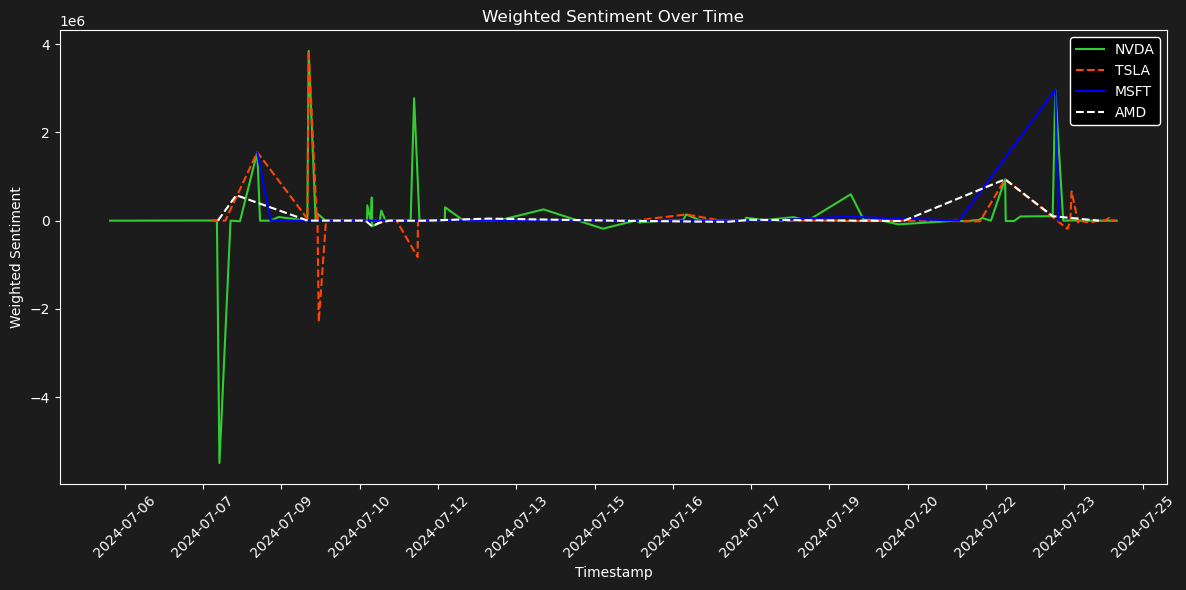

In [969]:
# Convert the timestamp column to datetime format
NVDA['timestamp'] = pd.to_datetime(NVDA['timestamp'])
TSLA['timestamp'] = pd.to_datetime(TSLA['timestamp'])
AMD['timestamp'] = pd.to_datetime(AMD['timestamp'])
MSFT['timestamp'] = pd.to_datetime(MSFT['timestamp'])

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the plot
ax = plt.subplot()

# Set the dark background
plt.style.use('dark_background')
plt.gca().set_facecolor('#1C1C1C')  # Dark background for the plot
plt.gcf().set_facecolor('#1C1C1C')  # Dark background for the figure

# Plot NVDA sentiment over time with green dotted line
sns.lineplot(x="timestamp", y="weighted_sentiment", data=NVDA, ax=ax, label='NVDA', color='#32CD32', linestyle='-')

# Plot TSLA sentiment over time with red line
sns.lineplot(x="timestamp", y="weighted_sentiment", data=TSLA, ax=ax, label='TSLA', color='#FF4500', linestyle="dashed")

# Plot MSFT sentiment over time with blue line
sns.lineplot(x="timestamp", y="weighted_sentiment", data=MSFT, ax=ax, label='MSFT', color='blue')

# Plot AMD sentiment over time with white line
sns.lineplot(x="timestamp", y="weighted_sentiment", data=AMD, ax=ax, label='AMD', color='#FFFFFF',linestyle="--")

# Format the x-axis to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=35))  # Adjust the interval as needed

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, color='white')

# Add labels and title with white text
plt.xlabel('Timestamp', color='white')
plt.ylabel('Weighted Sentiment', color='white')
plt.title('Weighted Sentiment Over Time', color='white')

# Customize the legend
plt.legend(facecolor='black', edgecolor='white', framealpha=1)

# Display the plot
plt.tight_layout()

# Save the plot to a file
plt.savefig('sentiment_impact_over_time_plot.png')

# Show the plot
plt.show()